## bulldozer-price-prediction-model

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.


## Data
**Thhe data is taken from the Kaggle Platform**

*The data for this competition is split into three parts:*

- Train.csv is the training set, which contains data through the end of 2011.
- Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
# importing training and validation data
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

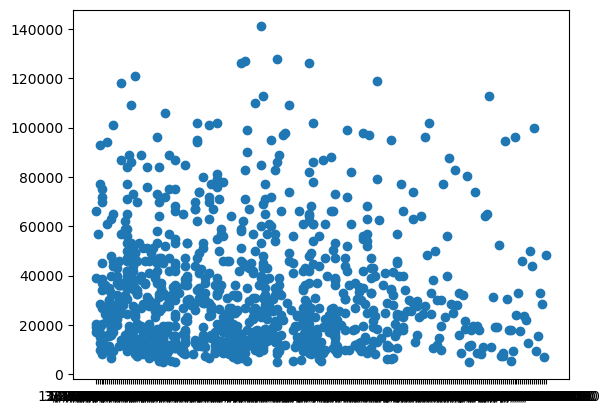

In [5]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

In [6]:
df['saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

## Parsing date and time

We try to make the at most use of datetime data type, while dealing with time-series data types

The parsing can be done during the time of importing the dataset itlsef by telling pandas which columns conatins the datetime object. This can be done using `parse_dates` attribute in `read_csv` method.

- put `low_memory = False` so that the data is not manipulated during the process of importing. This is done while working with large datasets.

In [7]:
# importing the dataset again, but by parsing thr date column this time
df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv',
                low_memory = False,
                parse_dates = ['saledate'])

In [8]:
df['saledate'].dtype

dtype('<M8[ns]')

In [9]:
df['saledate']

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

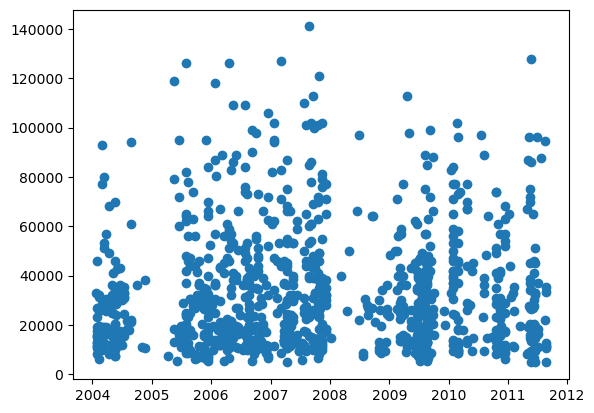

In [10]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

In [11]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


## sort the dataset by datetime in ascending order

In [12]:
df.sort_values(by=['saledate'], ascending = True, inplace = True)

In [13]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


## Make copy of the original dataset
so that even when we anipulate the data we got our original data with

In [14]:
df_copy = df.copy()

## Enrich the dataset by extracting various attributes form datetime

In [15]:
df_copy['saleYear'] = df_copy.saledate.dt.year
df_copy['saleMonth'] = df_copy.saledate.dt.month
df_copy['saleday'] = df_copy.saledate.dt.day
df_copy['saleDayOfWeek'] = df_copy.saledate.dt.dayofweek
df_copy['saleDayOfYear'] = df_copy.saledate.dt.dayofyear

In [16]:
# since we have extracted from the 'saledate' column, we do not need it anymore in the dataset
df_copy.drop('saledate', axis = 1, inplace = True)

In [17]:
len(df_copy.state.unique())

53

## Modelling based EDA

In [18]:
for label,content in df_copy.items():
    print(label,content, '\n')

SalesID 205615    1646770
274835    1821514
141296    1505138
212552    1671174
62755     1329056
           ...   
410879    6302984
412476    6324811
411927    6313029
407124    6266251
409203    6283635
Name: SalesID, Length: 412698, dtype: int64 

SalePrice 205615     9500.0
274835    14000.0
141296    50000.0
212552    16000.0
62755     22000.0
           ...   
410879    16000.0
412476     6000.0
411927    16000.0
407124    55000.0
409203    34000.0
Name: SalePrice, Length: 412698, dtype: float64 

MachineID 205615    1126363
274835    1194089
141296    1473654
212552    1327630
62755     1336053
           ...   
410879    1915521
412476    1919104
411927    1918416
407124     509560
409203    1869284
Name: MachineID, Length: 412698, dtype: int64 

ModelID 205615     8434
274835    10150
141296     4139
212552     8591
62755      4089
          ...  
410879     5266
412476    19330
411927    17244
407124     3357
409203     4701
Name: ModelID, Length: 412698, dtype: int64 

data

In [19]:
# checking the percentage of unique values in each feature

df_cols = df_copy.columns

In [20]:
for col in df_cols[1:]:
    print(col, ":", (len(df_copy[col].unique())))

SalePrice : 954
MachineID : 348808
ModelID : 5281
datasource : 6
auctioneerID : 31
YearMade : 73
MachineHoursCurrentMeter : 15634
UsageBand : 4
fiModelDesc : 5059
fiBaseModel : 1961
fiSecondaryDesc : 178
fiModelSeries : 124
fiModelDescriptor : 141
ProductSize : 7
fiProductClassDesc : 74
state : 53
ProductGroup : 6
ProductGroupDesc : 6
Drive_System : 5
Enclosure : 7
Forks : 3
Pad_Type : 5
Ride_Control : 4
Stick : 3
Transmission : 9
Turbocharged : 3
Blade_Extension : 3
Blade_Width : 7
Enclosure_Type : 4
Engine_Horsepower : 3
Hydraulics : 13
Pushblock : 3
Ripper : 5
Scarifier : 3
Tip_Control : 4
Tire_Size : 18
Coupler : 4
Coupler_System : 3
Grouser_Tracks : 3
Hydraulics_Flow : 4
Track_Type : 3
Undercarriage_Pad_Width : 20
Stick_Length : 30
Thumb : 4
Pattern_Changer : 4
Grouser_Type : 4
Backhoe_Mounting : 3
Blade_Type : 11
Travel_Controls : 8
Differential_Type : 5
Steering_Controls : 6
saleYear : 24
saleMonth : 12
saleday : 31
saleDayOfWeek : 7
saleDayOfYear : 361


In [21]:
for col in df_cols[1:]:
    print(col, ":", (len(df_copy[col].unique())/len(df_copy))*100)

SalePrice : 0.2311617696233081
MachineID : 84.51894605740759
ModelID : 1.2796282027051258
datasource : 0.0014538476076937617
auctioneerID : 0.007511545973084435
YearMade : 0.01768847922694077
MachineHoursCurrentMeter : 3.7882422497807116
UsageBand : 0.0009692317384625076
fiModelDesc : 1.2258358412204566
fiBaseModel : 0.4751658597812444
fiSecondaryDesc : 0.04313081236158159
fiModelSeries : 0.03004618389233774
fiModelDescriptor : 0.0341654187808034
ProductSize : 0.0016961555423093886
fiProductClassDesc : 0.017930787161556393
state : 0.012842320534628228
ProductGroup : 0.0014538476076937617
ProductGroupDesc : 0.0014538476076937617
Drive_System : 0.0012115396730781347
Enclosure : 0.0016961555423093886
Forks : 0.0007269238038468809
Pad_Type : 0.0012115396730781347
Ride_Control : 0.0009692317384625076
Stick : 0.0007269238038468809
Transmission : 0.0021807714115406425
Turbocharged : 0.0007269238038468809
Blade_Extension : 0.0007269238038468809
Blade_Width : 0.0016961555423093886
Enclosure_Typ

## Splitting the data into train anf test data asper th erules of Kaggle Bluebook for this competetion

In [22]:
df_train = df_copy[df_copy.saleYear != 2012]
df_val = df_copy[df_copy.saleYear == 2012]

In [23]:
cat_cols_train = []
num_cols_train = []
for col in df_train[1:]:
    if df_train[col].dtype == 'object':
        cat_cols_train.append(col)
    else:
        num_cols_train.append(col)
        
cat_cols_val = []
num_cols_val = []
for col in df_val[1:]:
    if df_val[col].dtype == 'object':
        cat_cols_val.append(col)
    else:
        num_cols_val.append(col)
        
cat_cols_train

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [24]:
num_cols_train

['SalesID',
 'SalePrice',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saleYear',
 'saleMonth',
 'saleday',
 'saleDayOfWeek',
 'saleDayOfYear']

In [25]:
cat_cols_val

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [26]:
num_cols_val

['SalesID',
 'SalePrice',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saleYear',
 'saleMonth',
 'saleday',
 'saleDayOfWeek',
 'saleDayOfYear']

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cat_cols_train:
    df_train[col] = le.fit_transform(df_train[col])

for col in cat_cols_val:
    df_val[col] = le.fit_transform(df_val[col])

C:\Users\srich\AppData\Local\Temp\ipykernel_50476\320587999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col] = le.fit_transform(df_train[col])
C:\Users\srich\AppData\Local\Temp\ipykernel_50476\320587999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col] = le.fit_transform(df_train[col])
C:\Users\srich\AppData\Local\Temp\ipykernel_50476\320587999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\srich\AppData\Local\Temp\ipykernel_50476\320587999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col] = le.fit_transform(df_train[col])
C:\Users\srich\AppData\Local\Temp\ipykernel_50476\320587999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col] = le.fit_transform(df_train[col])
C:\Users\srich\AppData\Local\Temp\ipykernel_50476\320587999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

C:\Users\srich\AppData\Local\Temp\ipykernel_50476\320587999.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[col] = le.fit_transform(df_val[col])
C:\Users\srich\AppData\Local\Temp\ipykernel_50476\320587999.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[col] = le.fit_transform(df_val[col])
C:\Users\srich\AppData\Local\Temp\ipykernel_50476\320587999.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [28]:
from sklearn.impute import SimpleImputer

numeric_imputer = SimpleImputer(strategy='median')
df_train[num_cols_train] = numeric_imputer.fit_transform(df_train[num_cols_train])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df_train[cat_cols_train] = categorical_imputer.fit_transform(df_train[cat_cols_train])


numeric_imputer = SimpleImputer(strategy='median')
df_val[num_cols_val] = numeric_imputer.fit_transform(df_val[num_cols_val])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df_val[cat_cols_val] = categorical_imputer.fit_transform(df_val[cat_cols_val])

C:\Users\srich\AppData\Local\Temp\ipykernel_50476\2802699862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[num_cols_train] = numeric_imputer.fit_transform(df_train[num_cols_train])
C:\Users\srich\AppData\Local\Temp\ipykernel_50476\2802699862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[cat_cols_train] = categorical_imputer.fit_transform(df_train[cat_cols_train])
C:\Users\srich\AppData\Local\Temp\ipykernel_50476\2802699862.py:11: SettingWithCopyWarning: 
A value is trying to be

In [29]:
df_train.info()

df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 393123
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  float64
 1   SalePrice                 401125 non-null  float64
 2   MachineID                 401125 non-null  float64
 3   ModelID                   401125 non-null  float64
 4   datasource                401125 non-null  float64
 5   auctioneerID              401125 non-null  float64
 6   YearMade                  401125 non-null  float64
 7   MachineHoursCurrentMeter  401125 non-null  float64
 8   UsageBand                 401125 non-null  int32  
 9   fiModelDesc               401125 non-null  int32  
 10  fiBaseModel               401125 non-null  int32  
 11  fiSecondaryDesc           401125 non-null  int32  
 12  fiModelSeries             401125 non-null  int32  
 13  fiModelDescriptor         401125 non-null  i

In [30]:
df_train.isnull().sum()

df_val.isnull().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper    

In [31]:
x_train, y_train = df_train.drop('SalePrice', axis = 1), df_train.SalePrice
x_val, y_val = df_val.drop('SalePrice', axis = 1), df_val.SalePrice

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((401125, 56), (401125,), (11573, 56), (11573,))

In [32]:
%%time

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs = -1,
                             random_state = 42)

'''model.fit(df_copy.drop('SalePrice', axis=1), df_copy['SalePrice'])'''

CPU times: total: 31.2 ms
Wall time: 94.4 ms


"model.fit(df_copy.drop('SalePrice', axis=1), df_copy['SalePrice'])"

## Building the evaluation function as per the rules of Kaggle Bluebook of Buldozers

In [33]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
    
def rmsle(y_test, y_pred):
    '''calculates the Root Mean Sqaure Log Error, as per the requirement given in Kaggle BlueBook Buldozer contest'''
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

def show_scores(model):
    train_pred = model.predict(x_train)
    val_pred = model.predict(x_val)
    
    '''we evaluate for training set also to make sure that training data is not performing better than validation. If it is not like
    that, it means our model is overfitting'''
    
    scores = {'Training MAE' : mean_absolute_error(y_train, train_pred),
              'Validation MAE' : mean_absolute_error(y_val, val_pred),
              'Training RMSLE' : rmsle(y_train, train_pred),
              'Validation RMSLE' : rmsle(y_val, val_pred),
              'Training R^2' : r2_score(y_train, train_pred),
              'Validation R^2' : r2_score(y_val, val_pred)}
    return scores

In [34]:
%%time

''' training the model over the entire dataset would consume quite a lot of time, rather for time being let us consider
    10000 rows'''

model = RandomForestRegressor(n_jobs = -1,
                             random_state = 42,
                             max_samples = 10000)

model.fit(x_train, y_train)

show_scores(model)

CPU times: total: 1min 14s
Wall time: 6.3 s


{'Training MAE': 5594.488644163292,
 'Validation MAE': 15589.55662490279,
 'Training RMSLE': 0.2603386367313689,
 'Validation RMSLE': 0.6081646306023591,
 'Training R^2': 0.8588233855879619,
 'Validation R^2': 0.39790874993895486}

## Hyperparamete tuning using RandomizedSearchCV

In [35]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators" : np.arange(10, 100, 10),
           "max_depth" : [None, 3,35, 10],
           "min_samples_split" : np.arange(2, 20, 2),
           "min_samples_leaf" : np.arange(1, 20, 2),
           "max_features" : [0.5, 0.75, 1.0, 'sqrt'],
           "max_samples" : [10000]}

rs_model = RandomizedSearchCV(model,
                             param_distributions = rf_grid,
                             n_iter = 100,
                             cv = 5,
                             verbose = True)

rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 7min 17s
Wall time: 14min 56s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_samples=10000, n_jobs=-1,
                                                   random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 35, 10],
                                        'max_features': [0.5, 0.75, 1.0,
                                                         'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [36]:
# finding the best parameters
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 0.75,
 'max_depth': 35}

## training with our best parameters

In [41]:
%%time
    
best_model = RandomForestRegressor(n_estimators= 90,
                                   min_samples_split = 6,
                                   min_samples_leaf= 3,
                                   max_samples = None,
                                   max_features = 0.75,
                                   max_depth = 35,
                                   n_jobs = -1,
                                   random_state = 42)

best_model.fit(x_train, y_train)

CPU times: total: 13min 46s
Wall time: 1min


RandomForestRegressor(max_depth=35, max_features=0.75, min_samples_leaf=3,
                      min_samples_split=6, n_estimators=90, n_jobs=-1,
                      random_state=42)

In [42]:
show_scores(best_model)

{'Training MAE': 2393.187704512602,
 'Validation MAE': 14474.87814871213,
 'Training RMSLE': 0.12390856422503155,
 'Validation RMSLE': 0.5800002659228364,
 'Training R^2': 0.9701449009624403,
 'Validation R^2': 0.4922465138982124}

In [43]:
show_scores(rs_model)

{'Training MAE': 5740.451533439119,
 'Validation MAE': 13292.372266726925,
 'Training RMSLE': 0.2646170848493657,
 'Validation RMSLE': 0.536274384544773,
 'Training R^2': 0.8505184715639083,
 'Validation R^2': 0.5873463661809682}

## importing test data

In [90]:
df_test_raw = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                          low_memory=False,
                         parse_dates = ['saledate'])

## Building a proprocessing function to preprocess the testing data

In [91]:
def data_preprocess(df_test):
        
    ''' parsing the date column same as of tarining data'''
    df_test['saleYear'] = df_test.saledate.dt.year
    df_test['saleMonth'] = df_test.saledate.dt.month
    df_test['saleday'] = df_test.saledate.dt.day
    df_test['saleDayOfWeek'] = df_test.saledate.dt.dayofweek
    df_test['saleDayOfYear'] = df_test.saledate.dt.dayofyear
    df_test.drop('saledate', axis = 1, inplace = True)
    
    cat_cols_test = []
    num_cols_test = []
    for col in df_test[1:]:
        if df_test[col].dtype == 'object':
            cat_cols_test.append(col)
        else:
            num_cols_test.append(col)
            
            
    '''coverting the categorical data into numerical data/numerical labels'''
    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()

    for col in cat_cols_test:
        df_test[col] = le.fit_transform(df_test[col])


    ''' imputing the missing values'''
    from sklearn.impute import SimpleImputer

    numeric_imputer = SimpleImputer(strategy='median')
    df_test[num_cols_test] = numeric_imputer.fit_transform(df_test[num_cols_test])

    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df_test[cat_cols_test] = categorical_imputer.fit_transform(df_test[cat_cols_test])
        
    return df_test

In [92]:
df_test = data_preprocess(df_test_raw)

In [94]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  float64
 1   MachineID                 12457 non-null  float64
 2   ModelID                   12457 non-null  float64
 3   datasource                12457 non-null  float64
 4   auctioneerID              12457 non-null  float64
 5   YearMade                  12457 non-null  float64
 6   MachineHoursCurrentMeter  12457 non-null  float64
 7   UsageBand                 12457 non-null  int32  
 8   fiModelDesc               12457 non-null  int32  
 9   fiBaseModel               12457 non-null  int32  
 10  fiSecondaryDesc           12457 non-null  int32  
 11  fiModelSeries             12457 non-null  int32  
 12  fiModelDescriptor         12457 non-null  int32  
 13  ProductSize               12457 non-null  int32  
 14  fiProd

In [95]:
df_test.isnull().sum()

SalesID                     0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper                      0
Scarifier 

In [96]:
# make predictions on test data
test_pred = best_model.predict(df_test)

In [98]:
len(test_pred)

12457

## the predicted dataset is nt the format of Kaggle's requirement, we need build the new predicted dataset, which is very simple

In [100]:
df_pred = pd.DataFrame()

df_pred['SalesID'] = df_test['SalesID']
df_pred['SalesPrice'] = test_pred

df_pred

,SalesID,SalesPrice
0,1227829.0,36690.103585
1,1227844.0,33623.452652
2,1227847.0,53254.127986
3,1227848.0,80309.980960
4,1227863.0,47715.906917
...,...,...
12452,6643171.0,74082.065697
12453,6643173.0,46618.379845
12454,6643184.0,16543.109067
12455,6643186.0,50994.583935


In [101]:
df_pred.to_csv('data/bluebook-for-bulldozers/TestPredictions.csv', index=False)

## Feature importance
*Feature importance speaks about, how much each feature has contributed to the prediction*

In [102]:
best_model.feature_importances_

array([4.21405274e-02, 2.36502654e-02, 5.94611678e-02, 1.00761283e-03,
       3.71812137e-03, 2.22459049e-01, 2.97727943e-03, 9.19564155e-04,
       4.57058757e-02, 5.45992636e-02, 2.59994687e-02, 3.89441319e-03,
       1.35214076e-02, 2.01333860e-01, 4.61674113e-02, 7.32605569e-03,
       3.05806664e-03, 2.62565695e-03, 1.26304297e-03, 4.89015502e-02,
       6.55418785e-04, 9.72931688e-04, 2.26511911e-03, 1.72162442e-04,
       6.99909530e-04, 6.69049465e-05, 2.92965237e-03, 2.40300238e-03,
       2.52700049e-03, 1.78068981e-03, 1.68399213e-03, 2.82709767e-03,
       6.37472421e-03, 6.39283206e-04, 1.83843410e-03, 1.40972506e-02,
       1.29014130e-03, 2.53294595e-02, 4.86136546e-03, 3.16309293e-03,
       1.17580441e-03, 1.43998528e-03, 1.42772932e-03, 5.50408911e-04,
       4.24302872e-04, 8.29987229e-04, 5.23091415e-04, 1.70396904e-03,
       2.39144100e-03, 1.76009052e-04, 2.15405857e-04, 7.47331250e-02,
       3.87152466e-03, 7.43891047e-03, 3.59256219e-03, 1.21984506e-02])

In [103]:
len(best_model.feature_importances_)

56

In [106]:
df_test.shape

(12457, 56)

In [107]:
df = (pd.DataFrame({'features' : df_test.columns,
                   'importances' : best_model.feature_importances_})
     .sort_values('importances', ascending = False)
     .reset_index(drop = True))

In [108]:
df

,features,importances
0,YearMade,0.222459
1,ProductSize,0.201334
2,saleYear,0.074733
3,ModelID,0.059461
4,fiBaseModel,0.054599
5,Enclosure,0.048902
6,fiProductClassDesc,0.046167
7,fiModelDesc,0.045706
8,SalesID,0.042141
9,fiSecondaryDesc,0.025999


Text(0.5, 1.0, 'Bar Graph of feature importance')

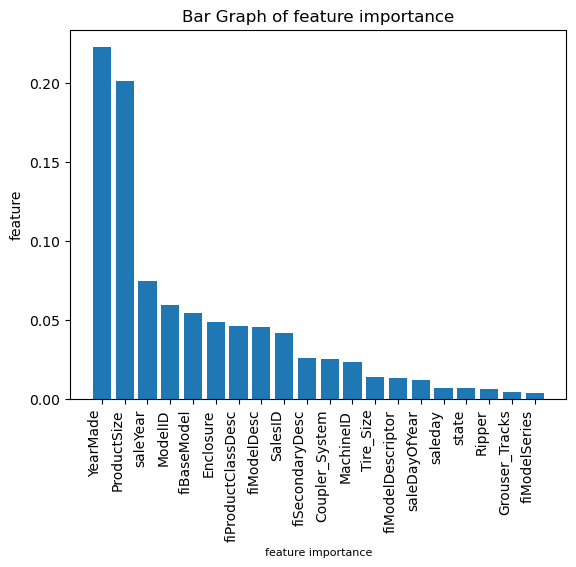

In [115]:
# Creating the bar plot
plt.bar(df['features'][:20], df['importances'][:20])

# Adding labels and title
plt.xlabel('feature importance', fontsize=8)
plt.xticks(rotation=90, ha='right')
plt.ylabel('feature')
plt.title('Bar Graph of feature importance')
